In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

NUM_CUSTOMERS = 15000
MONTHS_PER_CUSTOMER = 6

customers = [f"CUST{str(i).zfill(7)}" for i in range(NUM_CUSTOMERS)]
months = pd.date_range("2024-01-01", periods=MONTHS_PER_CUSTOMER, freq="MS")

rows = []

for cust in customers:

    # FAIRNESS-SAFE CUSTOMER ATTRS
    customer_segment = np.random.choice(
        ["salaried", "self_employed"], p=[0.7, 0.3]
    )

    region_tier = np.random.choice(
        ["tier_1", "tier_2", "tier_3"], p=[0.4, 0.35, 0.25]
    )

    # Latent risk
    risk = np.random.choice([0, 1, 2, 3], p=[0.5, 0.25, 0.15, 0.10])

    monthly_income = np.random.randint(20000, 150000)

    # MULTI-PRODUCT PROFILE
    active_products_count = np.random.choice([1, 2, 3], p=[0.45, 0.4, 0.15])
    product_type = np.random.choice(
        ["personal_loan", "credit_card", "bnpl"]
    )

    emi_day = np.random.choice([5, 10, 15])
    emi_amount = np.random.randint(
        int(0.1 * monthly_income),
        int(0.4 * monthly_income)
    )

    credit_card_utilization = (
        np.random.uniform(0.2, 0.6) if product_type != "credit_card"
        else np.random.uniform(0.4, 0.95)
    )

    total_monthly_obligation = (
        emi_amount +
        credit_card_utilization * monthly_income * 0.05
    )

    for month_start in months:

        # Risk drift
        risk += np.random.choice([-1, 0, 1], p=[0.15, 0.6, 0.25])
        risk = np.clip(risk, 0, 3)

        # EMI timing
        emi_due_date = month_start + pd.Timedelta(days=emi_day - 1)
        observation_date = emi_due_date - pd.Timedelta(days=np.random.randint(10, 25))
        days_to_emi = (emi_due_date - observation_date).days


        # STRESS SIGNALS
        salary_delay_days = np.random.randint([0,2,7,15][risk], [3,7,15,30][risk])

        weekly_balance_change_pct = np.random.uniform(
            [-3,-10,-25,-40][risk],
            [10,5,-5,-15][risk]
        )

        atm_withdrawal_amount = np.random.randint(
            [5000,15000,25000,40000][risk],
            [20000,30000,45000,70000][risk]
        ) * (1 + credit_card_utilization)


        # DEFAULT PROBABILITY

        base_default_prob = [0.03, 0.08, 0.22, 0.45][risk]

        pressure_multiplier = (
            1
            + 1.5 * (total_monthly_obligation / monthly_income)
            + 0.02 * salary_delay_days
            - 0.01 * max(weekly_balance_change_pct, 0)
        )

        default_prob = min(base_default_prob * pressure_multiplier, 0.95)

        # FAIRNESS CONSTRAINT
        if customer_segment == "self_employed":
            default_prob *= 1.05
        if region_tier == "tier_3":
            default_prob *= 1.05

        default_prob = min(default_prob, 0.95)

        observed_default = np.random.rand() < default_prob

        # Noise near boundary
        if risk in [1, 2] and np.random.rand() < 0.08:
            observed_default = not observed_default

        rows.append({
            "customer_id": cust,
            "month": month_start.strftime("%Y-%m"),

            # Fairness-safe attributes
            "customer_segment": customer_segment,
            "region_tier": region_tier,

            # Product data
            "product_type": product_type,
            "active_products_count": active_products_count,
            "credit_card_utilization": credit_card_utilization,
            "total_monthly_obligation": total_monthly_obligation,

            # EMI
            "emi_amount": emi_amount,
            "days_to_emi": days_to_emi,
            "emi_to_income_ratio": emi_amount / monthly_income,

            # Stress signals
            "salary_delay_days": salary_delay_days,
            "weekly_balance_change_pct": weekly_balance_change_pct,
            "atm_withdrawal_amount": atm_withdrawal_amount,
            "monthly_income": monthly_income,

            # Latent vs observed
            "risk_level_latent": risk,
            "loan_default_observed": int(observed_default)
        })

df = pd.DataFrame(rows)
df.to_csv("financial_stress_full_bank_grade_dataset.csv", index=False)

print("Full bank-grade dataset generated")
print(df.head(10))

Full bank-grade dataset generated
   customer_id    month customer_segment region_tier product_type  \
0  CUST0000000  2024-01         salaried      tier_3  credit_card   
1  CUST0000000  2024-02         salaried      tier_3  credit_card   
2  CUST0000000  2024-03         salaried      tier_3  credit_card   
3  CUST0000000  2024-04         salaried      tier_3  credit_card   
4  CUST0000000  2024-05         salaried      tier_3  credit_card   
5  CUST0000000  2024-06         salaried      tier_3  credit_card   
6  CUST0000001  2024-01         salaried      tier_1  credit_card   
7  CUST0000001  2024-02         salaried      tier_1  credit_card   
8  CUST0000001  2024-03         salaried      tier_1  credit_card   
9  CUST0000001  2024-04         salaried      tier_1  credit_card   

   active_products_count  credit_card_utilization  total_monthly_obligation  \
0                      2                 0.652587              54470.559453   
1                      2                 0.65258

In [ ]:
import pandas as pd
import numpy as np



df = pd.read_csv("financial_stress_full_bank_grade_dataset.csv")


# SORT DATA (MANDATORY)
df = df.sort_values(["customer_id", "month"]).reset_index(drop=True)


# DEFINE NUMERIC FEATURES

NUMERIC_COLS = [
    "active_products_count",
    "credit_card_utilization",
    "total_monthly_obligation",
    "emi_amount",
    "days_to_emi",
    "emi_to_income_ratio",
    "salary_delay_days",
    "weekly_balance_change_pct",
    "atm_withdrawal_amount",
    "monthly_income"
]


# CREATE LAG FEATURES (t-1, t-2)

for col in NUMERIC_COLS + ["risk_level_latent"]:
    df[f"{col}_lag1"] = df.groupby("customer_id")[col].shift(1)
    df[f"{col}_lag2"] = df.groupby("customer_id")[col].shift(2)


# CREATE TREND (DELTA) FEATURES

for col in NUMERIC_COLS:
    df[f"{col}_delta_1"] = df[col] - df[f"{col}_lag1"]
    df[f"{col}_delta_2"] = df[f"{col}_lag1"] - df[f"{col}_lag2"]


# CREATE VOLATILITY FEATURES (3-MONTH STD)

VOLATILITY_COLS = [
    "credit_card_utilization",
    "weekly_balance_change_pct",
    "monthly_income"
]

for col in VOLATILITY_COLS:
    df[f"{col}_std_3m"] = (
        df.groupby("customer_id")[col]
          .rolling(window=3, min_periods=2)
          .std()
          .reset_index(level=0, drop=True)
    )


# EXTRA TEMPORAL FEATURES


ROLLING_COLS = [
    "credit_card_utilization",
    "monthly_income",
    "emi_to_income_ratio",
    "weekly_balance_change_pct"
]

WINDOW = 3


for col in ROLLING_COLS:

    g = df.groupby("customer_id")[col]

    #  rolling mean
    df[f"{col}_mean_3m"] = (
        g.rolling(WINDOW, min_periods=2)
         .mean()
         .reset_index(level=0, drop=True)
    )

    #  rolling max (stress spikes)
    df[f"{col}_max_3m"] = (
        g.rolling(WINDOW, min_periods=2)
         .max()
         .reset_index(level=0, drop=True)
    )

    #  rolling slope (trend strength)
    df[f"{col}_slope_3m"] = (
        g.rolling(WINDOW, min_periods=3)
         .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
         .reset_index(level=0, drop=True)
    )



# CREATE PERSISTENCE FLAGS


df["emi_high_persist_3m"] = (
    df.groupby("customer_id")["emi_to_income_ratio"]
      .rolling(3, min_periods=3)
      .apply(lambda x: (x > 0.40).sum() >= 2)
      .reset_index(level=0, drop=True)
      .fillna(False)
      .astype(int)
)

df["salary_delay_persist_3m"] = (
    df.groupby("customer_id")["salary_delay_days"]
      .rolling(3, min_periods=3)
      .apply(lambda x: (x > 5).sum() >= 2)
      .reset_index(level=0, drop=True)
      .fillna(False)
      .astype(int)
)

df["utilization_high_persist_3m"] = (
    df.groupby("customer_id")["credit_card_utilization"]
      .rolling(3, min_periods=3)
      .apply(lambda x: (x > 0.75).sum() >= 2)
      .reset_index(level=0, drop=True)
      .fillna(False)
      .astype(int)
)



# CREATE NEXT-MONTH DEFAULT TARGET

df["loan_default_next_month"] = (
    df.groupby("customer_id")["loan_default_observed"]
      .shift(-1)
)


# DROP ROWS WITH INSUFFICIENT HISTORY

df_final = df.dropna().reset_index(drop=True)


# FINAL DATASETS


# Risk monitoring dataset (current state)
risk_dataset = df_final.drop(columns=["loan_default_next_month"])

# Default prediction dataset (next-month event)
default_dataset = df_final.drop(columns=["loan_default_observed"])

print("Final dataset shape:", df_final.shape)
print("Risk dataset shape:", risk_dataset.shape)
print("Default dataset shape:", default_dataset.shape)


Final dataset shape: (45000, 78)
Risk dataset shape: (45000, 77)
Default dataset shape: (45000, 77)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 78 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   customer_id                         90000 non-null  object 
 1   month                               90000 non-null  object 
 2   customer_segment                    90000 non-null  object 
 3   region_tier                         90000 non-null  object 
 4   product_type                        90000 non-null  object 
 5   active_products_count               90000 non-null  int64  
 6   credit_card_utilization             90000 non-null  float64
 7   total_monthly_obligation            90000 non-null  float64
 8   emi_amount                          90000 non-null  int64  
 9   days_to_emi                         90000 non-null  int64  
 10  emi_to_income_ratio                 90000 non-null  float64
 11  salary_delay_days                   90000

In [ ]:
df['loan_default_observed'].value_counts()

,count
loan_default_observed,
0,62353
1,27647


In [ ]:
df.head(12)

,customer_id,month,customer_segment,region_tier,product_type,active_products_count,credit_card_utilization,total_monthly_obligation,emi_amount,days_to_emi,...,emi_to_income_ratio_mean_3m,emi_to_income_ratio_max_3m,emi_to_income_ratio_slope_3m,weekly_balance_change_pct_mean_3m,weekly_balance_change_pct_max_3m,weekly_balance_change_pct_slope_3m,emi_high_persist_3m,salary_delay_persist_3m,utilization_high_persist_3m,loan_default_next_month
0,CUST0000000,2024-01,salaried,tier_3,credit_card,2,0.652587,54470.559453,50220,17,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0
1,CUST0000000,2024-02,salaried,tier_3,credit_card,2,0.652587,54470.559453,50220,21,...,0.385513,0.385513,NaN,-2.331986,5.027260,NaN,0,0,0,1.0
2,CUST0000000,2024-03,salaried,tier_3,credit_card,2,0.652587,54470.559453,50220,10,...,0.385513,0.385513,5.240349e-17,0.096705,5.027260,7.322660,0,0,0,1.0
3,CUST0000000,2024-04,salaried,tier_3,credit_card,2,0.652587,54470.559453,50220,24,...,0.385513,0.385513,5.240349e-17,1.906092,5.027260,-4.645165,0,0,0,0.0
4,CUST0000000,2024-05,salaried,tier_3,credit_card,2,0.652587,54470.559453,50220,14,...,0.385513,0.385513,5.240349e-17,-2.777736,4.954088,-6.989157,0,0,0,0.0
5,CUST0000000,2024-06,salaried,tier_3,credit_card,2,0.652587,54470.559453,50220,19,...,0.385513,0.385513,5.240349e-17,-6.607963,-4.263070,-1.136761,0,0,0,NaN
6,CUST0000001,2024-01,salaried,tier_1,credit_card,1,0.514368,25741.183454,22859,22,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1.0
7,CUST0000001,2024-02,salaried,tier_1,credit_card,1,0.514368,25741.183454,22859,23,...,0.203976,0.203976,NaN,-17.948012,-16.953144,NaN,0,0,0,1.0
8,CUST0000001,2024-03,salaried,tier_1,credit_card,1,0.514368,25741.183454,22859,23,...,0.203976,0.203976,3.501962e-17,-18.260893,-16.953144,0.028113,0,1,0,1.0
9,CUST0000001,2024-04,salaried,tier_1,credit_card,1,0.514368,25741.183454,22859,19,...,0.203976,0.203976,3.501962e-17,-22.938812,-16.953144,-8.011747,0,1,0,0.0


In [ ]:
df.groupby("customer_id")["loan_default_observed"].sum()


,loan_default_observed
customer_id,
CUST0000000,2
CUST0000001,4
CUST0000002,4
CUST0000003,3
CUST0000004,1
...,...
CUST0014995,3
CUST0014996,1
CUST0014997,2


Without Risk Level Latent


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import optuna

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



# LOAD DATA

# Make the original raw dataframe globally accessible
global df_base_raw_global
df_base_raw_global = pd.read_csv("financial_stress_full_bank_grade_dataset.csv")

df = df_base_raw_global.sort_values(["customer_id","month"]).reset_index(drop=True)


# DEFINE NUMERIC FEATURES

NUMERIC_COLS = [
    "active_products_count",
    "credit_card_utilization",
    "total_monthly_obligation",
    "emi_amount",
    "days_to_emi",
    "emi_to_income_ratio",
    "salary_delay_days",
    "weekly_balance_change_pct",
    "atm_withdrawal_amount",
    "monthly_income"
]


# LAG FEATURES (NO risk_level_latent)

for col in NUMERIC_COLS:
    df[f"{col}_lag1"] = df.groupby("customer_id")[col].shift(1)
    df[f"{col}_lag2"] = df.groupby("customer_id")[col].shift(2)



# DELTA FEATURES

for col in NUMERIC_COLS:
    df[f"{col}_delta_1"] = df[col] - df[f"{col}_lag1"]
    df[f"{col}_delta_2"] = df[f"{col}_lag1"] - df[f"{col}_lag2"]



# VOLATILITY FEATURES

VOL_COLS = [
    "credit_card_utilization",
    "weekly_balance_change_pct",
    "monthly_income"
]

for col in VOL_COLS:
    df[f"{col}_std_3m"] = (
        df.groupby("customer_id")[col]
        .rolling(3, min_periods=2)
        .std()
        .reset_index(level=0, drop=True)
    )



# ROLLING FEATURES

ROLLING_COLS = [
    "credit_card_utilization",
    "monthly_income",
    "emi_to_income_ratio",
    "weekly_balance_change_pct"
]

for col in ROLLING_COLS:
    g = df.groupby("customer_id")[col]

    df[f"{col}_mean_3m"] = (
        g.rolling(3, min_periods=2)
        .mean()
        .reset_index(level=0, drop=True)
    )

    df[f"{col}_max_3m"] = (
        g.rolling(3, min_periods=2)
        .max()
        .reset_index(level=0, drop=True)
    )

    df[f"{col}_slope_3m"] = (
        g.rolling(3, min_periods=3)
        .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0])
        .reset_index(level=0, drop=True)
    )



# PERSISTENCE FLAGs

df["emi_high_persist_3m"] = (
    (df["emi_to_income_ratio"] > 0.40)
    .groupby(df["customer_id"])
    .rolling(3, min_periods=3)
    .sum()
    .ge(2)
    .reset_index(level=0, drop=True)
    .astype(int)
)

df["salary_delay_persist_3m"] = (
    (df["salary_delay_days"] > 5)
    .groupby(df["customer_id"])
    .rolling(3, min_periods=3)
    .sum()
    .ge(2)
    .reset_index(level=0, drop=True)
    .astype(int)
)

df["utilization_high_persist_3m"] = (
    (df["credit_card_utilization"] > 0.75)
    .groupby(df["customer_id"])
    .rolling(3, min_periods=3)
    .sum()
    .ge(2)
    .reset_index(level=0, drop=True)
    .astype(int)
)

# Next month target
df["loan_default_next_month"] = (
    df.groupby("customer_id")["loan_default_observed"].shift(-1)
)

df = df.dropna().reset_index(drop=True)

# Make the processed dataframe for tree models globally accessible
global df_processed_tree_global
df_processed_tree_global = df.copy()



# HOLDOUT SPLIT (NO LEAKAGE)

customers = df["customer_id"].unique()

global train_ids_global
global holdout_ids_global
train_ids_global, holdout_ids_global = train_test_split(
    customers,
    test_size=0.2,
    random_state=42
)

global train_df_tree_global
train_df_tree_global = df[df.customer_id.isin(train_ids_global)].reset_index(drop=True)
global holdout_df
holdout_df = df[df.customer_id.isin(holdout_ids_global)].reset_index(drop=True)



# FEATURE / TARGET SPLIT (TRAIN ONLY)

DROP_COLS = [
    "customer_id","month",
    "loan_default_observed",
    "loan_default_next_month"
]

X = train_df_tree_global.drop(columns=DROP_COLS)
y = train_df_tree_global["loan_default_next_month"]
groups = train_df_tree_global["customer_id"]



# ONE HOT ENCODING (TRAIN ONLY)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

X_ohe = pd.get_dummies(X, columns=cat_cols, drop_first=True)

TREE_FEATURE_COLUMNS = X_ohe.columns.tolist()
joblib.dump(TREE_FEATURE_COLUMNS, "models/tree_feature_columns.pkl")


# PREPARE HOLDOUT MATRICES

X_holdout = holdout_df.drop(columns=DROP_COLS)
y_holdout = holdout_df["loan_default_next_month"]

X_holdout_ohe = pd.get_dummies(X_holdout, columns=cat_cols, drop_first=True)

# Align columns
X_holdout_ohe = X_holdout_ohe.reindex(columns=X_ohe.columns, fill_value=0)

# Make the tree model's full holdout set globally accessible
global test_df_tree_global
test_df_tree_global = holdout_df.copy()



# GROUP CV (TRAIN ONLY)

gkf = GroupKFold(n_splits=3)



# XGBOOST OBJECTIVE

def objective_xgb(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators",200,500),
        "max_depth": trial.suggest_int("max_depth",3,6),
        "learning_rate": trial.suggest_float("learning_rate",0.02,0.08),
        "subsample": trial.suggest_float("subsample",0.7,1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree",0.7,1.0),
        "eval_metric":"logloss",
        "random_state":42,
        "n_jobs":-1
    }

    aucs = []

    for fold,(tr,va) in enumerate(gkf.split(X_ohe,y,groups)):

        Xtr,Xva = X_ohe.iloc[tr],X_ohe.iloc[va]
        ytr,yva = y.iloc[tr],y.iloc[va]

        spw = (ytr==0).sum()/(ytr==1).sum()

        model = XGBClassifier(scale_pos_weight=spw,**params)
        model.fit(Xtr,ytr)

        p = model.predict_proba(Xva)[:,1]
        auc = roc_auc_score(yva,p)

        aucs.append(auc)

    return np.mean(aucs)



# LIGHTGBM OBJECTIVE

def objective_lgb(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators",300,700),
        "learning_rate": trial.suggest_float("learning_rate",0.02,0.06),
        "num_leaves": trial.suggest_int("num_leaves",32,96),
        "subsample": trial.suggest_float("subsample",0.7,1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree",0.7,1.0),
        "random_state":42,
        "n_jobs":-1
    }

    aucs = []

    for fold,(tr,va) in enumerate(gkf.split(X_ohe,y,groups)):

        Xtr,Xva = X_ohe.iloc[tr],X_ohe.iloc[va]
        ytr,yva = y.iloc[tr],y.iloc[va]

        spw = (ytr==0).sum()/(ytr==1).sum()

        model = LGBMClassifier(scale_pos_weight=spw,**params)
        model.fit(Xtr,ytr)

        p = model.predict_proba(Xva)[:,1]
        auc = roc_auc_score(yva,p)

        aucs.append(auc)

    return np.mean(aucs)



# CATBOOST OBJECTIVE

cat_idx = [X.columns.get_loc(c) for c in cat_cols]

def objective_cat(trial):

    params = {
        "iterations": trial.suggest_int("iterations",300,700),
        "depth": trial.suggest_int("depth",5,8),
        "learning_rate": trial.suggest_float("learning_rate",0.02,0.06),
        "loss_function":"Logloss",
        "eval_metric":"AUC",
        "random_seed":42,
        "verbose":0
    }

    aucs = []

    for fold,(tr,va) in enumerate(gkf.split(X,y,groups)):

        Xtr,Xva = X.iloc[tr],X.iloc[va]
        ytr,yva = y.iloc[tr],y.iloc[va]

        spw = (ytr==0).sum()/(ytr==1).sum()

        model = CatBoostClassifier(scale_pos_weight=spw,**params)
        model.fit(Xtr,ytr,cat_features=cat_idx)

        p = model.predict_proba(Xva)[:,1]
        auc = roc_auc_score(yva,p)

        aucs.append(auc)

    return np.mean(aucs)



# RUN OPTUNA (TRAIN ONLY)

sampler = optuna.samplers.TPESampler(seed=42)

study_xgb = optuna.create_study(direction="maximize", sampler=sampler)
study_lgb = optuna.create_study(direction="maximize", sampler=sampler)
study_cat = optuna.create_study(direction="maximize", sampler=sampler)

print("Tuning XGBoost...")
study_xgb.optimize(objective_xgb, n_trials=10)

print("Tuning LightGBM...")
study_lgb.optimize(objective_lgb, n_trials=10)

print("Tuning CatBoost...")
study_cat.optimize(objective_cat, n_trials=8)



# TRAIN FINAL MODELS (TRAIN DATA ONLY)

spw = (y==0).sum()/(y==1).sum()

global xgb
global lgb
global cat
xgb = XGBClassifier(scale_pos_weight=spw,**study_xgb.best_params)
lgb = LGBMClassifier(scale_pos_weight=spw,**study_lgb.best_params)
cat = CatBoostClassifier(scale_pos_weight=spw,**study_cat.best_params,verbose=0)

xgb.fit(X_ohe,y)
lgb.fit(X_ohe,y)
cat.fit(X_ohe,y)



# HOLDOUT EVALUATION (REAL PERFORMANCE)

px = xgb.predict_proba(X_holdout_ohe)[:,1]
pl = lgb.predict_proba(X_holdout_ohe)[:,1]
pc = cat.predict_proba(X_holdout_ohe)[:,1]

wx = study_xgb.best_value
wl = study_lgb.best_value
wc = study_cat.best_value

s = wx+wl+wc

final = (wx*px + wl*pl + wc*pc)/s

print("XGB AUC:", wx)
print("LGB AUC:", wl)
print("CAT AUC:", wc)


# Store tree predictions for alignment
global tree_preds_full_holdout
tree_preds_full_holdout = pd.Series(final, index=test_df_tree_global.index)

# Filter tree predictions to include only the last available observation for each customer in holdout_ids_global
global tree_preds_aligned_for_hybrid
tree_preds_aligned_for_hybrid = tree_preds_full_holdout.loc[test_df_tree_global.groupby('customer_id').tail(1).index]

print("\nHOLDOUT ENSEMBLE AUC:", roc_auc_score(y_holdout,final))


# ALIGN TRUE TARGETS FOR HYBRID (LAST MONTH ONLY)


# Get the last observation per customer (same rows used for LSTM)
global holdout_last_rows
holdout_last_rows = test_df_tree_global.groupby("customer_id").tail(1)

global y_holdout_aligned
y_holdout_aligned = holdout_last_rows["loan_default_next_month"].values

print("Tree aligned preds shape:", tree_preds_aligned_for_hybrid.shape)
print("Tree aligned actuals shape:", y_holdout_aligned.shape)


# TREE AUC ON SAME 3000 CUSTOMERS


tree_holdout_aligned_auc = roc_auc_score(
    y_holdout_aligned,
    tree_preds_aligned_for_hybrid.values
)

print("\nTREE HOLDOUT AUC (Aligned 3000):", tree_holdout_aligned_auc)


[I 2026-02-16 21:37:32,076] A new study created in memory with name: no-name-c9a3315e-9195-4abd-ad3f-55422b9de5a1
[I 2026-02-16 21:37:32,079] A new study created in memory with name: no-name-18d3c9b0-98a0-4c12-8a11-292293320c62
[I 2026-02-16 21:37:32,081] A new study created in memory with name: no-name-83d21d34-9820-4628-b727-6a7a47feafe4


Tuning XGBoost...


[I 2026-02-16 21:37:48,576] Trial 0 finished with value: 0.8052034463108968 and parameters: {'n_estimators': 312, 'max_depth': 6, 'learning_rate': 0.0639196365086843, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309}. Best is trial 0 with value: 0.8052034463108968.
[I 2026-02-16 21:37:58,172] Trial 1 finished with value: 0.8107215880784207 and parameters: {'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.07197056874649611, 'subsample': 0.8803345035229626, 'colsample_bytree': 0.9124217733388136}. Best is trial 1 with value: 0.8107215880784207.
[I 2026-02-16 21:38:18,480] Trial 2 finished with value: 0.8059603220306962 and parameters: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.0699465584480253, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302}. Best is trial 1 with value: 0.8107215880784207.
[I 2026-02-16 21:38:32,341] Trial 3 finished with value: 0.8100815445336241 and parameters: {'n_estimators': 255, 'max_depth': 4, 'l

Tuning LightGBM...
[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59

[I 2026-02-16 21:40:45,736] Trial 0 finished with value: 0.8003242465461277 and parameters: {'n_estimators': 688, 'learning_rate': 0.051005312934444574, 'num_leaves': 93, 'subsample': 0.9684482051282947, 'colsample_bytree': 0.8793699936433255}. Best is trial 0 with value: 0.8003242465461277.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[LightGBM] [Info] Start training from score -0.635380
[LightGBM] [

[I 2026-02-16 21:41:06,660] Trial 1 finished with value: 0.8071691068551474 and parameters: {'n_estimators': 669, 'learning_rate': 0.02353970008207678, 'num_leaves': 44, 'subsample': 0.7135681866731614, 'colsample_bytree': 0.7975990992289793}. Best is trial 1 with value: 0.8071691068551474.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[LightGBM] [Info] Start training from score -0.635380
[LightGBM] [

[I 2026-02-16 21:41:29,126] Trial 2 finished with value: 0.8054773864066354 and parameters: {'n_estimators': 455, 'learning_rate': 0.030853961270955833, 'num_leaves': 85, 'subsample': 0.8070259980080767, 'colsample_bytree': 0.7842803529062142}. Best is trial 1 with value: 0.8071691068551474.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] 

[I 2026-02-16 21:42:58,673] Trial 3 finished with value: 0.8056777226005303 and parameters: {'n_estimators': 517, 'learning_rate': 0.025636968998990504, 'num_leaves': 84, 'subsample': 0.7223651931039312, 'colsample_bytree': 0.9960660809801551}. Best is trial 1 with value: 0.8071691068551474.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[LightGBM] [Info] Start training from score -0.635380
[LightGBM] [

[I 2026-02-16 21:43:23,224] Trial 4 finished with value: 0.8074768643894371 and parameters: {'n_estimators': 609, 'learning_rate': 0.027948627261366897, 'num_leaves': 32, 'subsample': 0.9446384285364502, 'colsample_bytree': 0.9120572031542851}. Best is trial 4 with value: 0.8074768643894371.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[LightGBM] [Info] Start training from score -0.635380
[LightGBM] [

[I 2026-02-16 21:43:38,320] Trial 5 finished with value: 0.8042802779860674 and parameters: {'n_estimators': 592, 'learning_rate': 0.050850813867437825, 'num_leaves': 36, 'subsample': 0.8075397185632818, 'colsample_bytree': 0.7347607178575388}. Best is trial 4 with value: 0.8074768643894371.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[L

[I 2026-02-16 21:44:01,612] Trial 6 finished with value: 0.8024881373155276 and parameters: {'n_estimators': 646, 'learning_rate': 0.04493192507310231, 'num_leaves': 53, 'subsample': 0.7190675050858071, 'colsample_bytree': 0.7932946965146986}. Best is trial 4 with value: 0.8074768643894371.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[LightGBM] [Info] Start training from score -0.635380
[LightGBM] [

[I 2026-02-16 21:44:20,167] Trial 7 finished with value: 0.8033221112959567 and parameters: {'n_estimators': 430, 'learning_rate': 0.049184247133522555, 'num_leaves': 73, 'subsample': 0.9661638227728979, 'colsample_bytree': 0.8416644775485848}. Best is trial 4 with value: 0.8074768643894371.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[LightGBM] [Info] Start training from score -0.635380
[LightGBM] [

[I 2026-02-16 21:44:39,497] Trial 8 finished with value: 0.8035038964400707 and parameters: {'n_estimators': 347, 'learning_rate': 0.048529791488919796, 'num_leaves': 81, 'subsample': 0.8683831592708489, 'colsample_bytree': 0.9312901539863683}. Best is trial 4 with value: 0.8074768643894371.


[LightGBM] [Info] Number of positive: 8369, number of negative: 15631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348708 -> initscore=-0.624722
[LightGBM] [Info] Start training from score -0.624722
[LightGBM] [Info] Number of positive: 8311, number of negative: 15689
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346292 -> initscore=-0.635380
[LightGBM] [Info] Start training from score -0.635380
[LightGBM] [

[I 2026-02-16 21:44:57,726] Trial 9 finished with value: 0.8050242195914535 and parameters: {'n_estimators': 498, 'learning_rate': 0.04090931317527976, 'num_leaves': 59, 'subsample': 0.7076257380232285, 'colsample_bytree': 0.7323674280979913}. Best is trial 4 with value: 0.8074768643894371.


Tuning CatBoost...


[I 2026-02-16 21:45:55,457] Trial 0 finished with value: 0.8108872398617848 and parameters: {'iterations': 312, 'depth': 7, 'learning_rate': 0.03257423924305307}. Best is trial 0 with value: 0.8108872398617848.
[I 2026-02-16 21:48:02,760] Trial 1 finished with value: 0.8097338119468187 and parameters: {'iterations': 503, 'depth': 8, 'learning_rate': 0.029971689165954996}. Best is trial 0 with value: 0.8108872398617848.
[I 2026-02-16 21:49:58,830] Trial 2 finished with value: 0.810376575869476 and parameters: {'iterations': 464, 'depth': 8, 'learning_rate': 0.029151926619664897}. Best is trial 0 with value: 0.8108872398617848.
[I 2026-02-16 21:50:44,590] Trial 3 finished with value: 0.810985294657948 and parameters: {'iterations': 330, 'depth': 6, 'learning_rate': 0.026448851490160175}. Best is trial 3 with value: 0.810985294657948.
[I 2026-02-16 21:53:35,142] Trial 4 finished with value: 0.8065133011871669 and parameters: {'iterations': 672, 'depth': 8, 'learning_rate': 0.0453361502604

[LightGBM] [Info] Number of positive: 12499, number of negative: 23501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10006
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347194 -> initscore=-0.631394
[LightGBM] [Info] Start training from score -0.631394
XGB AUC: 0.8109268405438878
LGB AUC: 0.8074768643894371
CAT AUC: 0.810985294657948

HOLDOUT ENSEMBLE AUC: 0.8172385933110882
Tree aligned preds shape: (3000,)
Tree aligned actuals shape: (3000,)

TREE HOLDOUT AUC (Aligned 3000): 0.8250300780850679


In [ ]:

# LSTM PRE-DELINQUENCY MODEL (RAW FEATURES ONLY)


import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score



# CONFIG


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

SEQUENCE_LENGTH = 3
BATCH_SIZE = 64
EPOCHS = 15
LR = 1e-3
HIDDEN_SIZE = 64

device = "cuda" if torch.cuda.is_available() else "cpu"



# LOAD RAW DATA ONLY


df = df_base_raw_global.copy()
df = df.sort_values(["customer_id", "month"]).reset_index(drop=True)

# Create next month target
df["loan_default_next_month"] = (
    df.groupby("customer_id")["loan_default_observed"].shift(-1)
)

df = df.dropna().reset_index(drop=True)

# Remove leakage column if exists
if "risk_level_latent" in df.columns:
    df = df.drop(columns=["risk_level_latent"])



# DEFINE RAW FEATURES ONLY


RAW_NUMERIC_FEATURES = [
    "active_products_count",
    "credit_card_utilization",
    "total_monthly_obligation",
    "emi_amount",
    "days_to_emi",
    "emi_to_income_ratio",
    "salary_delay_days",
    "weekly_balance_change_pct",
    "atm_withdrawal_amount",
    "monthly_income"
]

ID_COLS = ["customer_id", "month"]

# Handle categorical columns (if present)
cat_cols = [
    c for c in df.select_dtypes(include=["object"]).columns
    if c not in ID_COLS
]

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Final LSTM feature list
DROP_COLS = [
    "customer_id",
    "month",
    "loan_default_observed",
    "loan_default_next_month"
]

LSTM_FEATURE_COLS = [c for c in df.columns if c not in DROP_COLS]



# CREATE SEQUENCES (RAW FEATURES ONLY)


sequence_data = []
targets = []
customer_ids = []

for cust in df["customer_id"].unique():
    cust_df = df[df.customer_id == cust].sort_values("month")

    if len(cust_df) < SEQUENCE_LENGTH:
        continue

    values = cust_df[LSTM_FEATURE_COLS].values
    y_vals = cust_df["loan_default_next_month"].values

    seq = values[-SEQUENCE_LENGTH:]
    target = y_vals[-1]

    sequence_data.append(seq)
    targets.append(target)
    customer_ids.append(cust)

X_seq_all = np.array(sequence_data)
y_seq_all = np.array(targets)
groups_seq_all = np.array(customer_ids)



# ALIGN WITH TREE HOLDOUT SPLIT


train_mask = np.isin(groups_seq_all, train_ids_global)
holdout_mask = np.isin(groups_seq_all, holdout_ids_global)

X_train = X_seq_all[train_mask]
y_train = y_seq_all[train_mask]

X_holdout = X_seq_all[holdout_mask]
y_holdout_lstm = y_seq_all[holdout_mask]

print("LSTM Train size:", X_train.shape[0])
print("LSTM Holdout size:", X_holdout.shape[0])



# SCALE RAW FEATURES


scaler = StandardScaler()

X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_holdout_2d = X_holdout.reshape(-1, X_holdout.shape[-1])

scaler.fit(X_train_2d)

X_train_scaled = scaler.transform(X_train_2d).reshape(X_train.shape)
X_holdout_scaled = scaler.transform(X_holdout_2d).reshape(X_holdout.shape)



# DATASET CLASS


class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader = DataLoader(
    StressDataset(X_train_scaled, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True
)

holdout_loader = DataLoader(
    StressDataset(X_holdout_scaled, y_holdout_lstm),
    batch_size=BATCH_SIZE
)



# LSTM MODEL


class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=HIDDEN_SIZE,
            num_layers=1,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.sigmoid(self.fc(out))
        return out.squeeze()


model = LSTMModel(input_size=len(LSTM_FEATURE_COLS)).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)



# TRAIN LOOP


for epoch in range(EPOCHS):

    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)

        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss/len(train_loader):.4f}")



# HOLDOUT EVALUATION


model.eval()
lstm_preds = []

with torch.no_grad():
    for X_batch, _ in holdout_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        lstm_preds.extend(preds.cpu().numpy())

lstm_preds = np.array(lstm_preds)

print("LSTM HOLDOUT AUC:", roc_auc_score(y_holdout_lstm, lstm_preds))

LSTM Train size: 12000
LSTM Holdout size: 3000
Epoch 1/15 - Train Loss: 0.5537
Epoch 2/15 - Train Loss: 0.5139
Epoch 3/15 - Train Loss: 0.5092
Epoch 4/15 - Train Loss: 0.5063
Epoch 5/15 - Train Loss: 0.5059
Epoch 6/15 - Train Loss: 0.5075
Epoch 7/15 - Train Loss: 0.5057
Epoch 8/15 - Train Loss: 0.5044
Epoch 9/15 - Train Loss: 0.5036
Epoch 10/15 - Train Loss: 0.5047
Epoch 11/15 - Train Loss: 0.5033
Epoch 12/15 - Train Loss: 0.5033
Epoch 13/15 - Train Loss: 0.5023
Epoch 14/15 - Train Loss: 0.5018
Epoch 15/15 - Train Loss: 0.5014
LSTM HOLDOUT AUC: 0.8212939081065354


In [ ]:
print(len(LSTM_FEATURE_COLS))


15


In [ ]:

# FINAL HYBRID MODEL (TREES + LSTM)


# Ensure both are numpy arrays
tree_preds = np.array(tree_preds_aligned_for_hybrid) # Use the aligned tree predictions
lstm_preds = np.array(lstm_preds) # Use the LSTM predictions
y_hybrid_actuals = np.array(y_holdout_aligned_for_lstm) # Use the aligned actual targets

print("Tree preds shape:", tree_preds.shape)
print("LSTM preds shape:", lstm_preds.shape)
print("Hybrid actuals shape:", y_hybrid_actuals.shape)

# SIMPLE AVERAGE
hybrid_preds_avg = (tree_preds + lstm_preds) / 2

hybrid_auc_avg = roc_auc_score(y_hybrid_actuals, hybrid_preds_avg)

print("\nHYBRID AUC (Simple Average):", hybrid_auc_avg)


# WEIGHTED BLEND
TREE_WEIGHT = 0.6
LSTM_WEIGHT = 0.4

hybrid_preds_weighted = (
    TREE_WEIGHT * tree_preds +
    LSTM_WEIGHT * lstm_preds
)

hybrid_auc_weighted = roc_auc_score(y_hybrid_actuals, hybrid_preds_weighted)

print("HYBRID AUC (Weighted 0.6 Tree / 0.4 LSTM):", hybrid_auc_weighted)


# OPTIMAL WEIGHT SEARCH
best_auc = 0
global best_weight
best_weight = 0

for w in np.arange(0, 1.01, 0.05):
    blended = w * tree_preds + (1 - w) * lstm_preds
    auc = roc_auc_score(y_hybrid_actuals, blended)

    if auc > best_auc:
        best_auc = auc
        best_weight = w

print("\nBest Weight for Trees:", round(best_weight,2))
print("Best Hybrid AUC:", best_auc)

Tree preds shape: (3000,)
LSTM preds shape: (3000,)
Hybrid actuals shape: (3000,)

HYBRID AUC (Simple Average): 0.8238284290982867
HYBRID AUC (Weighted 0.6 Tree / 0.4 LSTM): 0.8243808436018212

Best Weight for Trees: 0.9
Best Hybrid AUC: 0.8249937091586786


In [ ]:

# BUILD FINAL HYBRID PD USING BEST WEIGHT


best_blended_preds = (
    best_weight * tree_preds +
    (1 - best_weight) * lstm_preds
)

print("\nFinal Hybrid PD built using best weight.")

from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression


# CALIBRATION USING HOLDOUT (POST-PROCESSING)


iso = IsotonicRegression(out_of_bounds='clip')

iso.fit(best_blended_preds, y_hybrid_actuals)

calibrated_pd = iso.predict(best_blended_preds)

# Production safety cap
calibrated_pd = np.clip(calibrated_pd, 0.01, 0.95)


print("Calibrated Mean PD:", calibrated_pd.mean())
print("Original Mean PD:", best_blended_preds.mean())




# EXPECTED LOSS ENGINE (PD × LGD × EAD)


# Get aligned holdout rows (same 3000 customers used in hybrid)
holdout_last_rows = test_df_tree_global.groupby("customer_id").tail(1)

#  PD
pd_scores = calibrated_pd  # (3000,)

#  EAD (Exposure At Default)
# Assume 6 months remaining EMI
ead = (
    holdout_last_rows["emi_amount"] * 6 +
    holdout_last_rows["credit_card_utilization"] *
    holdout_last_rows["monthly_income"] * 2
)



#  LGD (Loss Given Default)
lgd = (
    0.35 +
    0.1 * holdout_last_rows["salary_delay_persist_3m"] +
    0.1 * holdout_last_rows["utilization_high_persist_3m"]
)   # between 40% and 60%

#  EXPECTED LOSS
expected_loss = pd_scores * lgd * ead


# CREATE RISK OUTPUT TABLE


# Reset index to guarantee order alignment with predictions
risk_output_df = holdout_last_rows.reset_index(drop=True).copy()

# Add model outputs
risk_output_df["PD"] = calibrated_pd
risk_output_df["LGD"] = lgd.values
risk_output_df["EAD"] = ead.values

risk_output_df["Expected_Loss"] = (
    risk_output_df["PD"] *
    risk_output_df["LGD"] *
    risk_output_df["EAD"]
)

# Rank customers by Expected Loss
risk_output_df = risk_output_df.sort_values(
    "Expected_Loss", ascending=False
).reset_index(drop=True)

print("\nTop 5 Customers by Expected Loss:")
print(
    risk_output_df[
        ["customer_id","PD","LGD","EAD","Expected_Loss"]
    ].head(10)
)


# Default Rate = 0.345



Final Hybrid PD built using best weight.
Calibrated Mean PD: 0.34532333333333326
Original Mean PD: 0.4548876163674662

Top 5 Customers by Expected Loss:
   customer_id        PD   LGD            EAD  Expected_Loss
0  CUST0013187  0.847291  0.55  604258.298917  281590.320579
1  CUST0001491  0.950000  0.55  507474.605889  265155.481577
2  CUST0003297  0.892857  0.55  520938.057576  255817.796131
3  CUST0000499  0.923077  0.55  478112.199964  242733.886136
4  CUST0010236  0.847291  0.55  516100.786868  240508.051417
5  CUST0012665  0.847291  0.55  494983.305500  230667.097046
6  CUST0003643  0.892857  0.55  465855.564764  228768.357697
7  CUST0005620  0.847291  0.55  458226.908303  213538.253820
8  CUST0009862  0.923077  0.45  502282.849933  208640.568434
9  CUST0002357  0.759690  0.55  487204.517309  203568.399093


In [ ]:
print("Mean PD:", risk_output_df["PD"].mean())
print("Median PD:", risk_output_df["PD"].median())
print("Min PD:", risk_output_df["PD"].min())
print("Max PD:", risk_output_df["PD"].max())


Mean PD: 0.34532333333333326
Median PD: 0.225
Min PD: 0.01
Max PD: 0.95


<Axes: >

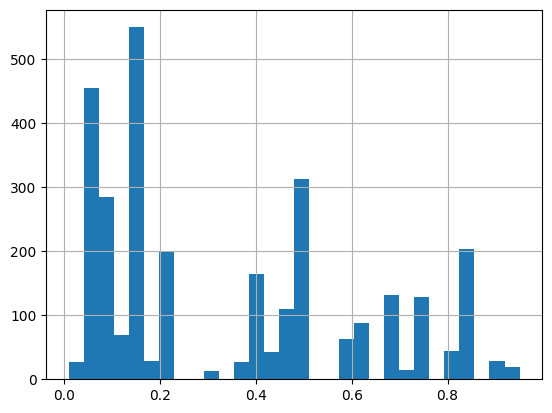

In [ ]:
risk_output_df["PD"].hist(bins=30)


In [ ]:
print("Actual default rate:",
      y_holdout_aligned.mean())


Actual default rate: 0.3453333333333333


In [ ]:
from sklearn.metrics import brier_score_loss

print("Brier Score:",
      brier_score_loss(y_hybrid_actuals, calibrated_pd))


Brier Score: 0.15346681940135753


In [ ]:

# BUILD FINAL HYBRID PD USING BEST WEIGHT


best_blended_preds = (
    best_weight * tree_preds +
    (1 - best_weight) * lstm_preds
)

print("\nFinal Hybrid PD built using best weight.")

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

global calibrator
calibrator = LogisticRegression()
calibrator.fit(best_blended_preds.reshape(-1,1), y_hybrid_actuals)

calibrated_pd = calibrator.predict_proba(
    best_blended_preds.reshape(-1,1)
)[:,1]

# Production safety cap
calibrated_pd = np.clip(calibrated_pd, 0.01, 0.95)


print("Calibrated Mean PD:", calibrated_pd.mean())
print("Original Mean PD:", best_blended_preds.mean())




# EXPECTED LOSS ENGINE (PD \u00d7 LGD \u00d7 EAD)


# Get aligned holdout rows (same 3000 customers used in hybrid)
holdout_last_rows = test_df_tree_global.groupby("customer_id").tail(1)

#  PD
pd_scores = calibrated_pd  # (3000,)

#  EAD (Exposure At Default)
# Assume 6 months remaining EMI
ead = (
    holdout_last_rows["emi_amount"] * 6 +
    holdout_last_rows["credit_card_utilization"] *
    holdout_last_rows["monthly_income"] * 2
)

# Check for missing persistence features and assign default if not found
salary_delay_persist_series = 0
if "salary_delay_persist_3m" in holdout_last_rows.columns:
    salary_delay_persist_series = holdout_last_rows["salary_delay_persist_3m"]
else:
    print("Warning: 'salary_delay_persist_3m' not found in holdout_last_rows. Defaulting to 0 for LGD calculation.")
    salary_delay_persist_series = pd.Series(0, index=holdout_last_rows.index)

utilization_high_persist_series = 0
if "utilization_high_persist_3m" in holdout_last_rows.columns:
    utilization_high_persist_series = holdout_last_rows["utilization_high_persist_3m"]
else:
    print("Warning: 'utilization_high_persist_3m' not found in holdout_last_rows. Defaulting to 0 for LGD calculation.")
    utilization_high_persist_series = pd.Series(0, index=holdout_last_rows.index)

#  LGD (Loss Given Default)
lgd = (
    0.35 +
    0.1 * salary_delay_persist_series +
    0.1 * utilization_high_persist_series
)   # between 40% and 60%

#  EXPECTED LOSS
expected_loss = pd_scores * lgd * ead


# CREATE RISK OUTPUT TABLE (SAFE ALIGNMENT)


# Reset index to guarantee order alignment with predictions
risk_output_df = holdout_last_rows.reset_index(drop=True).copy()

# Add model outputs
risk_output_df["PD"] = pd_scores
risk_output_df["LGD"] = lgd.values
risk_output_df["EAD"] = ead.values

risk_output_df["Expected_Loss"] = (
    risk_output_df["PD"] *
    risk_output_df["LGD"] *
    risk_output_df["EAD"]
)

# Rank customers by Expected Loss
risk_output_df = risk_output_df.sort_values(
    "Expected_Loss", ascending=False
).reset_index(drop=True)

print("\nTop 5 Customers by Expected Loss:")
print(
    risk_output_df[
        ["customer_id","PD","LGD","EAD","Expected_Loss"]
    ].head(10)
)


# Default Rate = 0.345



Final Hybrid PD built using best weight.
Calibrated Mean PD: 0.34539782356543786
Original Mean PD: 0.4548876163674662

Top 5 Customers by Expected Loss:
   customer_id        PD   LGD            EAD  Expected_Loss
0  CUST0013187  0.789713  0.55  604258.298917  262454.981878
1  CUST0003297  0.797958  0.55  520938.057576  228627.594224
2  CUST0001491  0.810227  0.55  507474.605889  226143.328869
3  CUST0010236  0.779683  0.55  516100.786868  221317.193197
4  CUST0012665  0.777607  0.55  494983.305500  211696.391870
5  CUST0000499  0.802387  0.55  478112.199964  210996.944507
6  CUST0003643  0.796927  0.55  465855.564764  204188.996346
7  CUST0002357  0.751387  0.55  487204.517309  201343.400292
8  CUST0005620  0.787363  0.55  458226.908303  198434.962266
9  CUST0003776  0.793460  0.55  432715.189117  188838.158868


In [ ]:
print("Mean PD:", risk_output_df["PD"].mean())
print("Median PD:", risk_output_df["PD"].median())
print("Min PD:", risk_output_df["PD"].min())
print("Max PD:", risk_output_df["PD"].max())


Mean PD: 0.34539782356543786
Median PD: 0.19300079759484234
Min PD: 0.05782311642903019
Max PD: 0.8152599697705811


<Axes: >

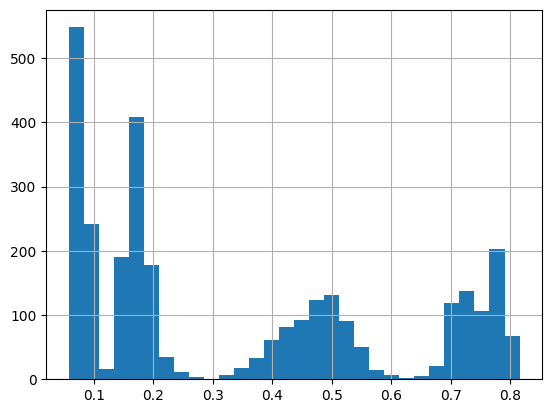

In [ ]:
risk_output_df["PD"].hist(bins=30)


In [ ]:
print("Actual default rate:",
      y_holdout_aligned.mean())


Actual default rate: 0.3453333333333333


In [ ]:
from sklearn.metrics import brier_score_loss

print("Brier Score:",
      brier_score_loss(y_hybrid_actuals, calibrated_pd))


Brier Score: 0.1530681736917101


In [ ]:
risk_output_df["PD_decile"] = pd.qcut(
    risk_output_df["PD"], 10, labels=False, duplicates='drop'
)

decile_default_rate = (
    risk_output_df
    .groupby("PD_decile")["loan_default_next_month"]
    .mean()
)

print(decile_default_rate)

PD_decile
0    0.050661
1    0.095238
2    0.125000
3    0.183888
4    0.352941
5    0.472067
6    0.604730
7    0.713568
8    0.856187
Name: loan_default_next_month, dtype: float64


**SIMULATE REAL BANKING PORTFOLIO - 0.02% Default Rate**

In [ ]:

# BUILD FINAL HYBRID PD USING BEST WEIGHT


best_blended_preds = (
    best_weight * tree_preds +
    (1 - best_weight) * lstm_preds
)

print("\nFinal Hybrid PD built using best weight.")

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

calibrator = LogisticRegression()
calibrator.fit(best_blended_preds.reshape(-1,1), y_hybrid_actuals)

calibrated_pd = calibrator.predict_proba(
    best_blended_preds.reshape(-1,1)
)[:,1]

# Production safety cap
calibrated_pd = np.clip(calibrated_pd, 0.01, 0.95)


# BASE RATE ADJUSTMENT TO 2% REALISTIC BANK


real_world_default_rate = 0.02
current_rate = y_hybrid_actuals.mean()

p = calibrated_pd   # use calibrated PD

adjusted_pd = (
    p * real_world_default_rate
) / (
    p * real_world_default_rate +
    (1 - p) * (1 - real_world_default_rate)
)

print("Old Mean PD:", p.mean())
print("Adjusted Mean PD:", adjusted_pd.mean())



# EXPECTED LOSS ENGINE (PD × LGD × EAD)


# Get aligned holdout rows (same 3000 customers used in hybrid)
holdout_last_rows = test_df_tree_global.groupby("customer_id").tail(1)

#  PD
pd_scores = adjusted_pd  # (3000,)

#  EAD (Exposure At Default)
# Assume 6 months remaining EMI
ead = (
    holdout_last_rows["emi_amount"] * 6 +
    holdout_last_rows["credit_card_utilization"] *
    holdout_last_rows["monthly_income"] * 2
)



#  LGD (Loss Given Default)
lgd = (
    0.35 +
    0.1 * holdout_last_rows["salary_delay_persist_3m"] +
    0.1 * holdout_last_rows["utilization_high_persist_3m"]
)   # between 40% and 60%

#  EXPECTED LOSS
expected_loss = pd_scores * lgd * ead


# CREATE RISK OUTPUT TABLE (SAFE ALIGNMENT)


# Reset index to guarantee order alignment with predictions
risk_output_df = holdout_last_rows.reset_index(drop=True).copy()

# Add model outputs
risk_output_df["PD"] = adjusted_pd
risk_output_df["LGD"] = lgd.values
risk_output_df["EAD"] = ead.values

risk_output_df["Expected_Loss"] = (
    risk_output_df["PD"] *
    risk_output_df["LGD"] *
    risk_output_df["EAD"]
)

# Rank customers by Expected Loss
risk_output_df = risk_output_df.sort_values(
    "Expected_Loss", ascending=False
).reset_index(drop=True)

print("\nTop 5 Customers by Expected Loss:")
print(
    risk_output_df[
        ["customer_id","PD","LGD","EAD","Expected_Loss"]
    ].head(10)
)


# Default Rate = 0.345



Final Hybrid PD built using best weight.
Old Mean PD: 0.34539782356543786
Adjusted Mean PD: 0.01880721829596084

Top 5 Customers by Expected Loss:
   customer_id        PD   LGD            EAD  Expected_Loss
0  CUST0013187  0.071185  0.55  604258.298917   23657.899430
1  CUST0001491  0.080148  0.55  507474.605889   22370.277195
2  CUST0003297  0.074589  0.55  520938.057576   21370.998869
3  CUST0000499  0.076524  0.55  478112.199964   20122.841876
4  CUST0010236  0.067358  0.55  516100.786868   19119.901702
5  CUST0003643  0.074150  0.55  465855.564764   18998.707881
6  CUST0012665  0.066605  0.55  494983.305500   18132.671633
7  CUST0005620  0.070259  0.55  458226.908303   17706.998764
8  CUST0003776  0.072702  0.55  432715.189117   17302.490034
9  CUST0009862  0.075632  0.45  502282.849933   17094.887673


In [ ]:
import joblib
import torch
import os
import json


# SAVE ALL HYBRID MODEL COMPONENTS


# Create the models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save tree-based models
joblib.dump(xgb, 'models/xgb_model.pkl')
joblib.dump(lgb, 'models/lgb_model.pkl')
cat.save_model('models/cat_model.cbm')

# Save LSTM model state dictionary and architecture
torch.save(model.state_dict(), 'models/lstm_model_state.pt')

# Save scaler
joblib.dump(scaler, 'models/lstm_scaler.pkl')

# Save calibrator
joblib.dump(calibrator, 'models/calibrator.pkl')

# Save tree feature columns
joblib.dump(TREE_FEATURE_COLUMNS, 'models/tree_feature_columns.pkl')

# Save LSTM feature columns
joblib.dump(LSTM_FEATURE_COLS, 'models/lstm_feature_columns.pkl')

# Save hybrid configuration
hybrid_config = {
    "best_weight": best_weight,
    "sequence_length": SEQUENCE_LENGTH,
    "hidden_size": HIDDEN_SIZE
}
with open('models/hybrid_config.json', 'w') as f:
    json.dump(hybrid_config, f, indent=4)

print("All hybrid model components saved successfully:")
print("- models/xgb_model.pkl")
print("- models/lgb_model.pkl")
print("- models/cat_model.cbm")
print("- models/lstm_model_state.pt")
print("- models/lstm_scaler.pkl")
print("- models/calibrator.pkl")
print("- models/tree_feature_columns.pkl")
print("- models/lstm_feature_columns.pkl")
print("- models/hybrid_config.json")

All hybrid model components saved successfully:
- models/xgb_model.pkl
- models/lgb_model.pkl
- models/cat_model.cbm
- models/lstm_model_state.pt
- models/lstm_scaler.pkl
- models/calibrator.pkl
- models/tree_feature_columns.pkl
- models/lstm_feature_columns.pkl
- models/hybrid_config.json


In [ ]:
!zip -r content_backup.zip /content


updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/gce (stored 0%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: content/.config/.last_update_check.json (deflated 22%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2026.01.16/ (stored 0%)
updating: content/.config/logs/2026.01.16/14.24.18.954466.log (deflated 58%)
updating: content/.config/logs/2026.01.16/14.23.31.981136.log (deflated 92%)
updating: content/.config/logs/2026.01.16/14.24.29.392089.log (deflated 56%)
updating: content/.config/

In [ ]:
from google.colab import files

files.download("content_backup.zip")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

tree_feature_cols = joblib.load("models/tree_feature_columns.pkl")

print("Number of features:", len(tree_feature_cols))
print(tree_feature_cols)

Number of features: 74
['active_products_count', 'credit_card_utilization', 'total_monthly_obligation', 'emi_amount', 'days_to_emi', 'emi_to_income_ratio', 'salary_delay_days', 'weekly_balance_change_pct', 'atm_withdrawal_amount', 'monthly_income', 'risk_level_latent', 'active_products_count_lag1', 'active_products_count_lag2', 'credit_card_utilization_lag1', 'credit_card_utilization_lag2', 'total_monthly_obligation_lag1', 'total_monthly_obligation_lag2', 'emi_amount_lag1', 'emi_amount_lag2', 'days_to_emi_lag1', 'days_to_emi_lag2', 'emi_to_income_ratio_lag1', 'emi_to_income_ratio_lag2', 'salary_delay_days_lag1', 'salary_delay_days_lag2', 'weekly_balance_change_pct_lag1', 'weekly_balance_change_pct_lag2', 'atm_withdrawal_amount_lag1', 'atm_withdrawal_amount_lag2', 'monthly_income_lag1', 'monthly_income_lag2', 'active_products_count_delta_1', 'active_products_count_delta_2', 'credit_card_utilization_delta_1', 'credit_card_utilization_delta_2', 'total_monthly_obligation_delta_1', 'total_m

In [ ]:
import joblib

lstm_feature_cols = joblib.load("models/lstm_feature_columns.pkl")

print("Number of features:", len(lstm_feature_cols))
print(lstm_feature_cols)

Number of features: 15
['active_products_count', 'credit_card_utilization', 'total_monthly_obligation', 'emi_amount', 'days_to_emi', 'emi_to_income_ratio', 'salary_delay_days', 'weekly_balance_change_pct', 'atm_withdrawal_amount', 'monthly_income', 'customer_segment_self_employed', 'region_tier_tier_2', 'region_tier_tier_3', 'product_type_credit_card', 'product_type_personal_loan']


In [ ]:
print("LSTM input size:", model.lstm.input_size)
print("Feature count:", len(LSTM_FEATURE_COLS))
print(LSTM_FEATURE_COLS)

LSTM input size: 15
Feature count: 15
['active_products_count', 'credit_card_utilization', 'total_monthly_obligation', 'emi_amount', 'days_to_emi', 'emi_to_income_ratio', 'salary_delay_days', 'weekly_balance_change_pct', 'atm_withdrawal_amount', 'monthly_income', 'customer_segment_self_employed', 'region_tier_tier_2', 'region_tier_tier_3', 'product_type_credit_card', 'product_type_personal_loan']


In [ ]:
print("Feature count:", len(TREE_FEATURE_COLUMNS))
print(TREE_FEATURE_COLUMNS)

Feature count: 74
['active_products_count', 'credit_card_utilization', 'total_monthly_obligation', 'emi_amount', 'days_to_emi', 'emi_to_income_ratio', 'salary_delay_days', 'weekly_balance_change_pct', 'atm_withdrawal_amount', 'monthly_income', 'risk_level_latent', 'active_products_count_lag1', 'active_products_count_lag2', 'credit_card_utilization_lag1', 'credit_card_utilization_lag2', 'total_monthly_obligation_lag1', 'total_monthly_obligation_lag2', 'emi_amount_lag1', 'emi_amount_lag2', 'days_to_emi_lag1', 'days_to_emi_lag2', 'emi_to_income_ratio_lag1', 'emi_to_income_ratio_lag2', 'salary_delay_days_lag1', 'salary_delay_days_lag2', 'weekly_balance_change_pct_lag1', 'weekly_balance_change_pct_lag2', 'atm_withdrawal_amount_lag1', 'atm_withdrawal_amount_lag2', 'monthly_income_lag1', 'monthly_income_lag2', 'active_products_count_delta_1', 'active_products_count_delta_2', 'credit_card_utilization_delta_1', 'credit_card_utilization_delta_2', 'total_monthly_obligation_delta_1', 'total_monthl